 <h3>Note : <b>All comment lines are Turkish</b><h3>

In [1]:

import pandas as pd #verilerin tutulması ve manipülasyonu
import numpy as np #makine öğrenmesi algoritmalarının giriş-çıkış verilerinin sayısal manipülasyonu
import matplotlib.pyplot as plt #verilerin görselleştirilmesi
import seaborn as sns #verilerin görselleştirilmesi (yukardaki ile benzer görev)
import nltk #doğal dil işleme
from nltk.corpus import stopwords #cümleler içinde sık sık geçen kısa uzunluktaki kelimeler, bağlaçlar...(and , for , because, a-an)
from nltk.tokenize import word_tokenize #metin madenciliği için mesela metinleri veya kelimeleri parçalara ayırma ve onları bu ayrıma göre sınıflandırma
import string #string işlemleri
from sklearn.feature_extraction.text import CountVectorizer #cümledeki kelimelerin kaç kez geçtiğini hesaplar
from sklearn.feature_extraction.text import TfidfTransformer #cümlede ağırlıklı olarak geçen kelimeleri istatiksel olarak hesaplayıp bir değer döndürür
from sklearn.naive_bayes import MultinomialNB #sınıflandırma algoritmamız
from sklearn.ensemble import RandomForestClassifier #sınıflandırma algoritmamız
from sklearn.tree import DecisionTreeClassifier #sınıflandırma algoritmamız
from sklearn.linear_model import LogisticRegression #sınıflandırma algoritmamız
from sklearn.ensemble import GradientBoostingClassifier #sınıflandırma algoritmamız
from xgboost import XGBClassifier #sınıflandırma algoritmamız
from sklearn.svm import SVC #sınıflandırma algoritmamız
from sklearn.model_selection import train_test_split #eğitime sokulacak ve tahmin edilmesi gerekecek verileri birbirinden ayırma
from sklearn.pipeline import Pipeline #aynı anda birçok algoritmamızı eğitime sokarak tahmin yapabilmesi için model oluşturacak iş parçacığı
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score #eğitilmiş modelin tahmin sonucunun gerçek değerle ne kadar uyuştuğunu gösterecek
import joblib #çeşitli algoritmalarımız ile eğitilen modellerinin kaydedilmesi
import math
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix






In [2]:
df = pd.read_csv("spam_ham_dataset.csv") #veriye biraz göz atalım
df.head(15)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [3]:
#veri hakkında bilgi edinilmesi
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


<h1><b>Data Preproccesing</b></h1>



In [4]:
df.dropna(inplace=True) #boş verileri silme işleminin yapılması

In [5]:
df.drop("Unnamed: 0", axis=1, inplace=True) #gereksiz sütunları silme işlemi

In [6]:
df.duplicated().sum() # aynı verileri göster

178

In [7]:
df.drop_duplicates(keep='first') #aynı verileri sil

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5165,ham,"Subject: fw : crosstex energy , driscoll ranch...",0
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


Text(0.5, 1.0, 'Spam and Ham')

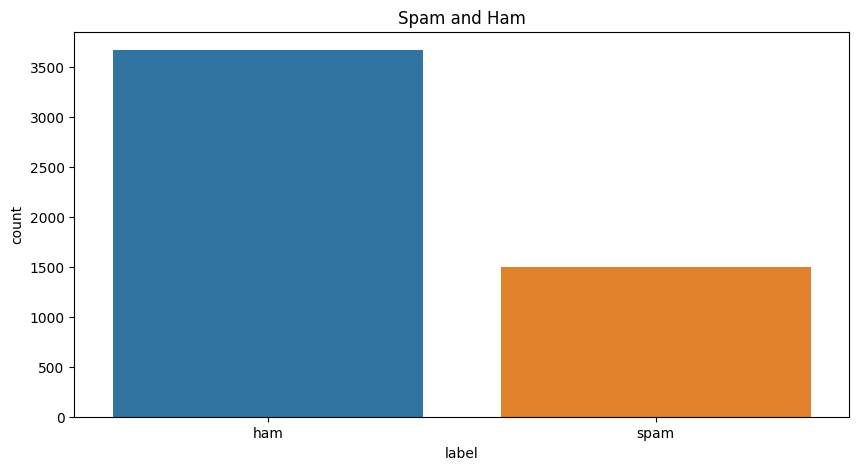

In [8]:
#kaç spam kaç ham göz atalım

plt.figure(figsize=(10,5))
sns.set_style()
sns.countplot(x='label',data=df)
plt.title('Spam and Ham')

In [9]:
df['label'].value_counts() # kaç ham kaç spam etiketli verimiz var ?

ham     3672
spam    1499
Name: label, dtype: int64

In [10]:
#aynı sütun içindeki konu ve text kısmını birbirinden ayırma işlemi

subjects = []
text = []

def split_subject(text_body):


    subject = ""
    for char in text_body:
        if char == '\r':
            break
        subject += char

    subjects.append(subject)
    text_body_after_subject = text_body[len(subject):]
    text.append(text_body_after_subject)




In [11]:
#ayırdığımız cümleyi dataframe kısmında gösterme işlemi
df["text"]=df["text"].str.replace("Subject:","")
df["text"].apply(split_subject)
df["subject"]=subjects
df["text"]=text
df.head()

,label,text,label_num,subject
0,ham,\r\nthis is a follow up to the note i gave you...,0,enron methanol ; meter # : 988291
1,ham,\r\n( see attached file : hplnol 09 . xls )\r\...,0,"hpl nom for january 9 , 2001"
2,ham,"\r\nho ho ho , we ' re around to that most won...",0,neon retreat
3,spam,\r\nabasements darer prudently fortuitous unde...,1,"photoshop , windows , office . cheap . main t..."
4,ham,\r\nthis deal is to book the teco pvr revenue ...,0,re : indian springs


In [12]:
#karışık olan sütünlarımızı düzeltme işlemi
df = df[['subject', 'text', 'label', 'label_num']]
df

,subject,text,label,label_num
0,enron methanol ; meter # : 988291,\r\nthis is a follow up to the note i gave you...,ham,0
1,"hpl nom for january 9 , 2001",\r\n( see attached file : hplnol 09 . xls )\r\...,ham,0
2,neon retreat,"\r\nho ho ho , we ' re around to that most won...",ham,0
3,"photoshop , windows , office . cheap . main t...",\r\nabasements darer prudently fortuitous unde...,spam,1
4,re : indian springs,\r\nthis deal is to book the teco pvr revenue ...,ham,0
...,...,...,...,...
5166,put the 10 on the ft,\r\nthe transport volumes decreased from 25000...,ham,0
5167,3 / 4 / 2000 and following noms,\r\nhpl can ' t take the extra 15 mmcf / d ove...,ham,0
5168,calpine daily gas nomination,"\r\n>\r\n>\r\njulie , as i mention earlier we ...",ham,0
5169,industrial worksheets for august 2000 activity,\r\nattached are the worksheets for august 200...,ham,0


In [13]:
#cümlelerin, noktalama işaretlerinden ve duraksama kelimelerinden arındılırılması işlemi

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:



def clean_text(text):

    text = ''.join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)




df.head()

,subject,text,label,label_num
0,enron methanol ; meter # : 988291,\r\nthis is a follow up to the note i gave you...,ham,0
1,"hpl nom for january 9 , 2001",\r\n( see attached file : hplnol 09 . xls )\r\...,ham,0
2,neon retreat,"\r\nho ho ho , we ' re around to that most won...",ham,0
3,"photoshop , windows , office . cheap . main t...",\r\nabasements darer prudently fortuitous unde...,spam,1
4,re : indian springs,\r\nthis deal is to book the teco pvr revenue ...,ham,0


In [15]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['subject'] = df['subject'].apply(lambda x: clean_text(x))


In [16]:

df.head()


,subject,text,label,label_num
0,enron methanol meter,follow note gave monday preliminary flow data ...,ham,0
1,hpl nom january,see attached file hplnol xls hplnol xls,ham,0
2,neon retreat,ho ho ho around wonderful time year neon leade...,ham,0
3,photoshop windows office cheap main trending,abasements darer prudently fortuitous undergon...,spam,1
4,indian springs,deal book teco pvr revenue understanding teco ...,ham,0


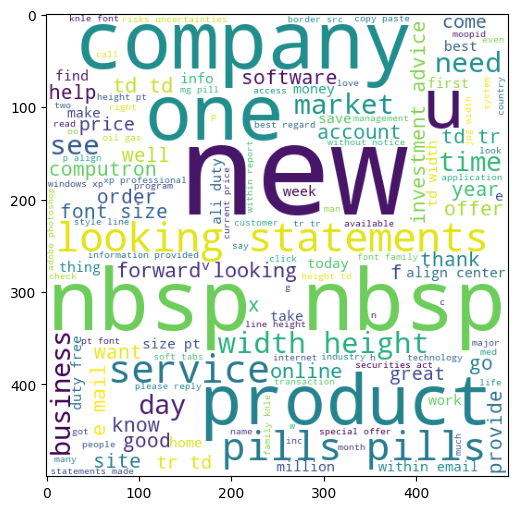

In [17]:
from wordcloud import WordCloud

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['label_num'] == 1]['text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()


In [18]:
spam_carpos = []
for sentence in df[df['label_num'] == 1]['text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

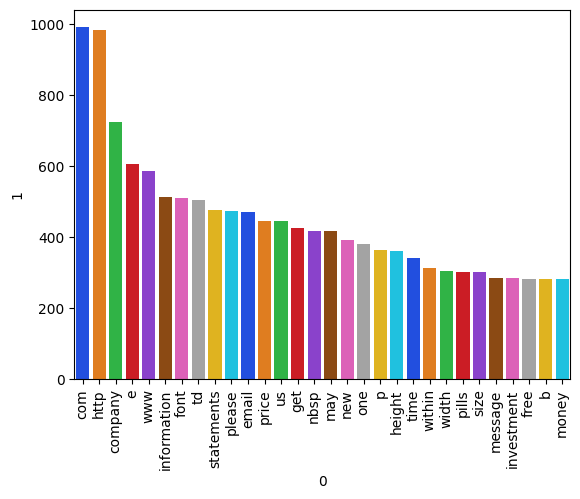

In [19]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

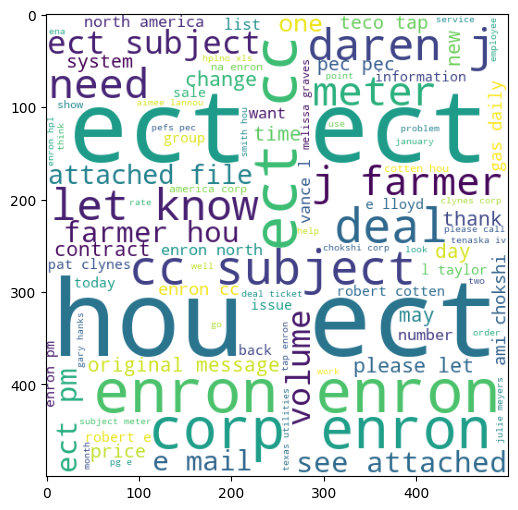

In [20]:

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['label_num'] == 0]['text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()


In [21]:
ham_carpos = []
for sentence in df[df['label_num'] == 0]['text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)



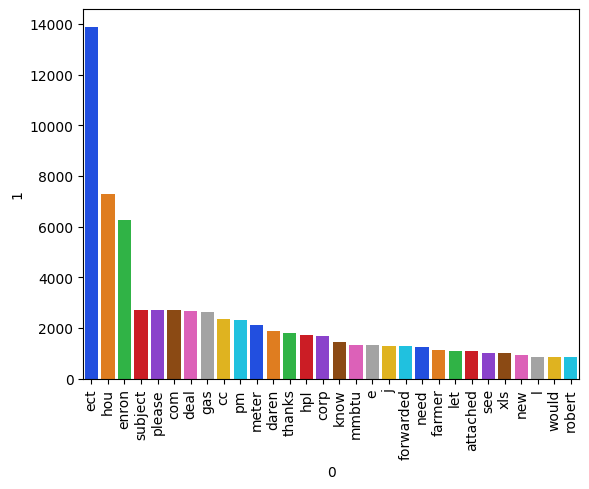

In [22]:
filter_ham_df = pd.DataFrame(Counter(ham_carpos).most_common(30))

sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

<h1><b>Makine Öğrenmesi</b><h1>

In [23]:


x= df['text']# algoritmalar tarafından beslenecek özelliklerin belirlenmesi (text sütunu)
y=df['label_num'] #yukardaki özelliğin karşılığı olan etiketleri
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=21) #özelliklerin ve etiketlerin, eğitime sokulma ve teste sokulma ayrımının yapılması


In [24]:
df

,subject,text,label,label_num
0,enron methanol meter,follow note gave monday preliminary flow data ...,ham,0
1,hpl nom january,see attached file hplnol xls hplnol xls,ham,0
2,neon retreat,ho ho ho around wonderful time year neon leade...,ham,0
3,photoshop windows office cheap main trending,abasements darer prudently fortuitous undergon...,spam,1
4,indian springs,deal book teco pvr revenue understanding teco ...,ham,0
...,...,...,...,...
5166,put ft,transport volumes decreased contract thanks am...,ham,0
5167,following noms,hpl take extra mmcf weekend try next week nom ...,ham,0
5168,calpine daily gas nomination,julie mention earlier hope start unit afternoo...,ham,0
5169,industrial worksheets august activity,attached worksheets august activity three diff...,ham,0


In [25]:
def create_pipeline_classifier(classifier):
    pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tf', TfidfTransformer()),
        ('classifier', classifier)
    ])

    return pipeline


model_mnb = create_pipeline_classifier(MultinomialNB())
model_rf = create_pipeline_classifier(RandomForestClassifier())
model_svc = create_pipeline_classifier(SVC())
model_dt = create_pipeline_classifier(DecisionTreeClassifier())
model_lgr = create_pipeline_classifier(LogisticRegression())
model_xgb = create_pipeline_classifier(XGBClassifier())
model_gbc = create_pipeline_classifier(GradientBoostingClassifier())







In [26]:
model_rf.fit(x_train,y_train)
model_mnb.fit(x_train,y_train)
model_svc.fit(x_train,y_train)
model_dt.fit(x_train,y_train)
model_lgr.fit(x_train,y_train)
model_xgb.fit(x_train,y_train)
model_gbc.fit(x_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tf', TfidfTransformer()),
                ('classifier', GradientBoostingClassifier())])

In [27]:


def predict_and_evaluate(models, x_test, y_test):
    models_with_preds = []
    accuracies = []

    for name, model in models.items():

        pred = model.predict(x_test)


        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted')
        f1 = f1_score(y_test, pred, average='weighted')


        model_with_pred = (model, pred)


        models_with_preds.append(model_with_pred)



        print(f'{name} Metrikler:')
        print(f'\tDoğruluk Skoru: {accuracy:.2f}')
        print(f'\tHassasiyet: {precision:.2f}')
        print(f'\tDuyarlılık: {recall:.2f}')
        print(f'\tF1 Skoru: {f1:.2f}')
        print('---')

    return models_with_preds

models = {
    'Random Forest': model_rf,
    'Multinomial NB': model_mnb,
    'SVC': model_svc,
    'Decision Tree': model_dt,
    'Logistic Regression': model_lgr,
    'XG Boost': model_xgb,
    'GBM': model_gbc
}


models_with_preds = predict_and_evaluate(models, x_test, y_test)



Random Forest Metrikler:
	Doğruluk Skoru: 0.97
	Hassasiyet: 0.97
	Duyarlılık: 0.97
	F1 Skoru: 0.97
---
Multinomial NB Metrikler:
	Doğruluk Skoru: 0.91
	Hassasiyet: 0.92
	Duyarlılık: 0.91
	F1 Skoru: 0.90
---
SVC Metrikler:
	Doğruluk Skoru: 0.98
	Hassasiyet: 0.98
	Duyarlılık: 0.98
	F1 Skoru: 0.98
---
Decision Tree Metrikler:
	Doğruluk Skoru: 0.95
	Hassasiyet: 0.95
	Duyarlılık: 0.95
	F1 Skoru: 0.95
---
Logistic Regression Metrikler:
	Doğruluk Skoru: 0.97
	Hassasiyet: 0.97
	Duyarlılık: 0.97
	F1 Skoru: 0.97
---
XG Boost Metrikler:
	Doğruluk Skoru: 0.96
	Hassasiyet: 0.96
	Duyarlılık: 0.96
	F1 Skoru: 0.96
---
GBM Metrikler:
	Doğruluk Skoru: 0.95
	Hassasiyet: 0.95
	Duyarlılık: 0.95
	F1 Skoru: 0.95
---


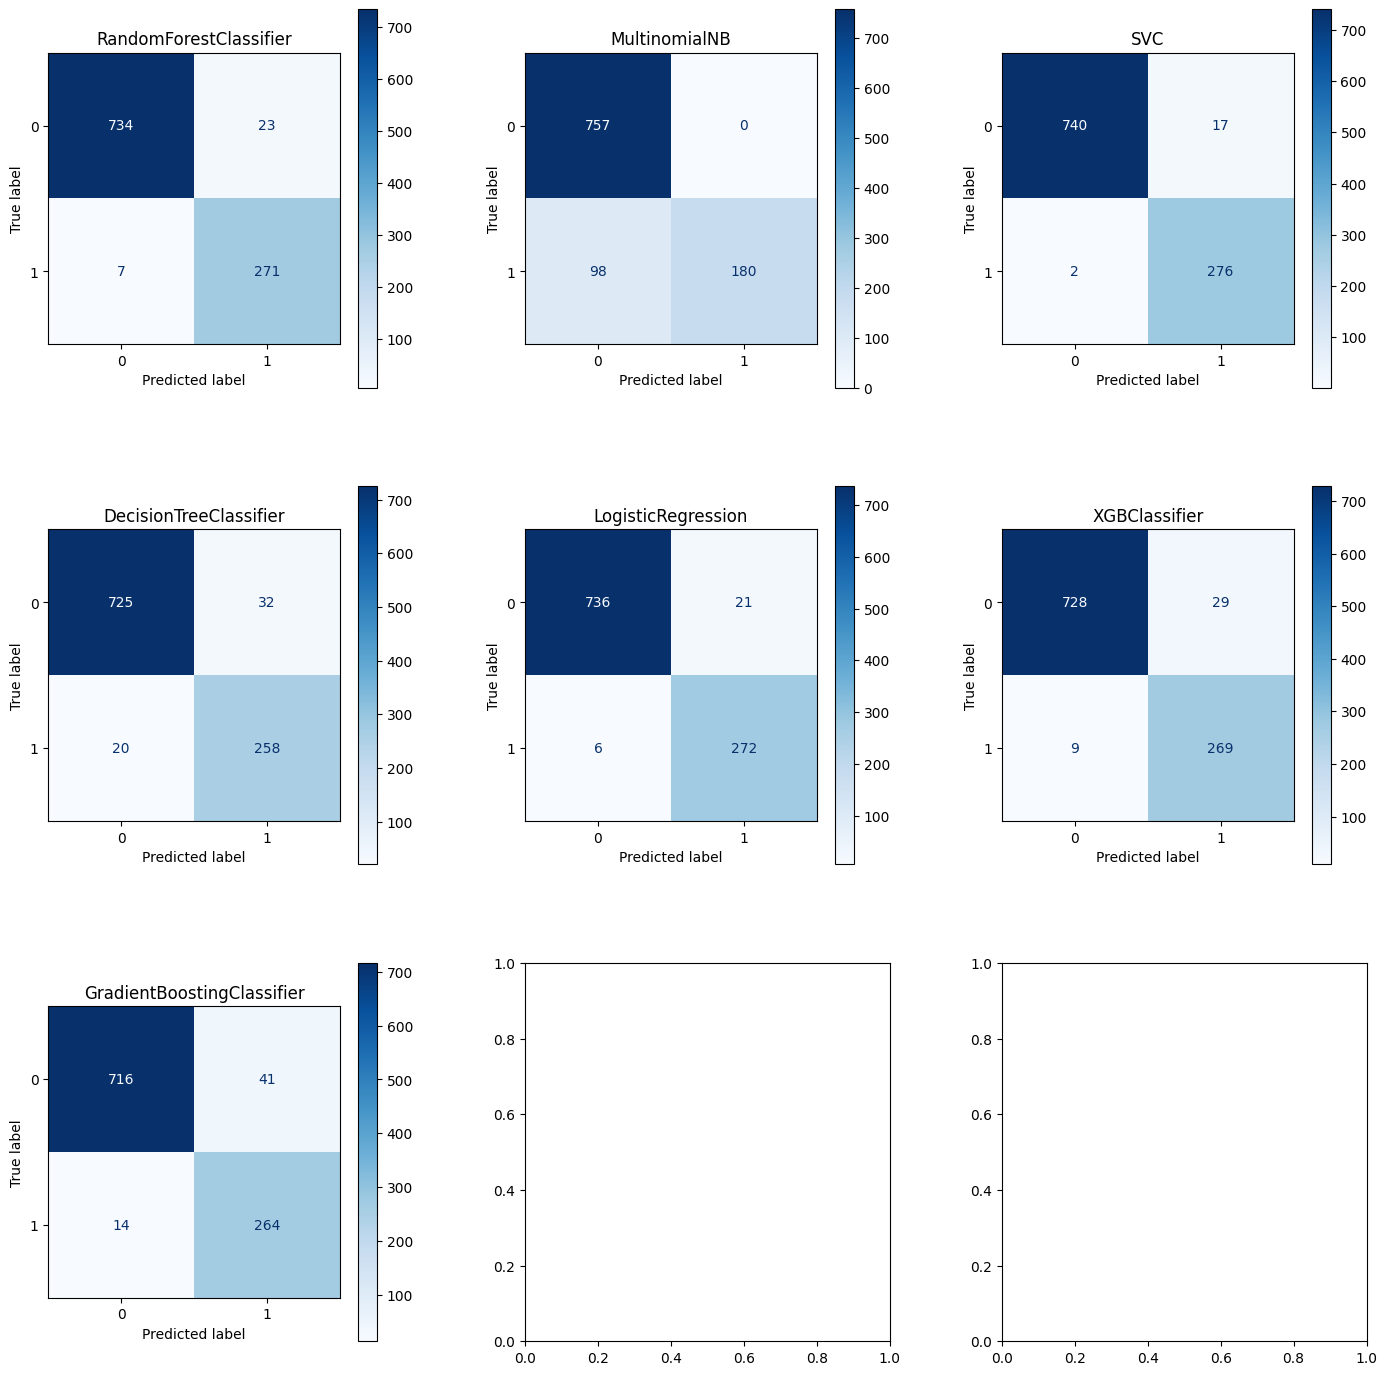

In [28]:



def showConfusion_matrix(models_with_preds, y_test=y_test):
    num_models = len(models_with_preds)
    rows, cols = math.ceil(num_models / 3), min(3, num_models)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), squeeze=False)
    plt.tight_layout(pad=5)

    for (model, pred_values), ax in zip(models_with_preds, axes.flatten()):
        cm = confusion_matrix(y_test, pred_values)
        display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        display_cm.plot(ax=ax,cmap='Blues')

        classifier_name = [step[1].__class__.__name__ for step in model.steps if step[0] == 'classifier']
        ax.set_title(classifier_name[0] if classifier_name else 'Confusion Matrix')

    plt.show()

showConfusion_matrix(models_with_preds)

In [29]:
#eğitilmiş modellerin ağırlıklarını dosyalara kaydetme işlemi


joblib.dump(model_rf, 'model_rf.pkl')

joblib.dump(model_gbc, 'model_gbc.pkl')

joblib.dump(model_xgb, 'model_xgb.pkl')

joblib.dump(model_mnb, 'model_mnb.pkl')

joblib.dump(model_svc, 'model_svc.pkl')

joblib.dump(model_dt, 'model_dt.pkl')

joblib.dump(model_lgr, 'model_lgr.pkl')

#Hadi web uygulalamıza geçelim --> detect_app.py

['model_lgr.pkl']

In [37]:
import joblib #model kaydetme, tekrar tekrar kullanma işlemini sağlar


model = joblib.load("ml_models/model_svc.pkl")

metin= "hello my name is Velat I am from Turkey can I come here ?"

metin=clean_text(metin)

tahmin = model.predict([metin]) #metin tahmin edilir
if tahmin[0] == 1: #tahmin bir etiket üretir, eğer bu etiket "1" ise spamdır.
          print("spam")

else:

          print("ham")

spam
